# Support Vector Machines: College Admission

Let's look at a classification example in Spark MLLib.  We looked at the college admission before. We can look again at this dataset.  


In [20]:
%matplotlib inline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pandas as pd



## Step 1: Load the data

In [7]:
dataset = spark.read.csv("/data/college-admissions/admission-data.csv", header=True, inferSchema=True)


In [3]:
dataset.show(20)

+-----+---+----+----+
|admit|gre| gpa|rank|
+-----+---+----+----+
|    0|380|3.61|   3|
|    1|660|3.67|   3|
|    1|800| 4.0|   1|
|    1|640|3.19|   4|
|    0|520|2.93|   4|
|    1|760| 3.0|   2|
|    1|560|2.98|   1|
|    0|400|3.08|   2|
|    1|540|3.39|   3|
|    0|700|3.92|   2|
|    0|800| 4.0|   4|
|    0|440|3.22|   1|
|    1|760| 4.0|   1|
|    0|700|3.08|   2|
|    1|700| 4.0|   1|
|    0|480|3.44|   3|
|    0|780|3.87|   4|
|    0|360|2.56|   3|
|    0|800|3.75|   2|
|    1|540|3.81|   1|
+-----+---+----+----+
only showing top 20 rows



## Step 2: Visualize the data

We cannot visualize the data because there is too many components. However, we can use PCA as
a dimensionality reduction technique to visualize it.

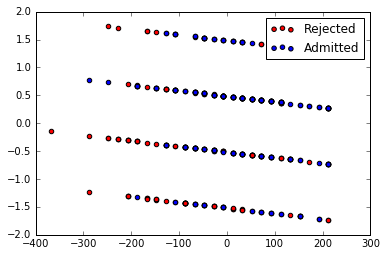

In [4]:
pca = PCA(n_components=2)

data = dataset.toPandas()

y = data['admit']          # Split off classifications
X = data.ix[:, 'gre':] # Split off features
#X_norm = (X - X.min())/(X.max() - X.min())
#transformed = pd.DataFrame(pca.fit_transform(X_norm))
transformed = pd.DataFrame(pca.fit_transform(X))

transformed

plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Rejected', c='red')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Admitted', c='blue')

plt.legend()




How separable does this data appear to be?  Do you notice any trends in the red and blue dots?

## Step 3: Build the Vector

**=> Build the vector with these three columns: admit, gre, gpa ** 

In [9]:
assembler = VectorAssembler(inputCols=['???', '???', '????'], outputCol="features")
featureVector = assembler.transform(training)
featureVector = featureVector.withColumnRenamed("admit", "label")

## Step 4: Split into training and test.

**=> Split into training/test with an 80/20 split ** 

In [10]:
## Split into training and test
## TODO: create training and test with an 80/20 split
(training, test) = dataset.randomSplit([???, ???])

## Step 5: Build the Linear SVM model

In [11]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(featureVector)

# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))


Coefficients: [2.42455427163,-0.000132348504168,-0.288668099055]
Intercept: -0.20541972695085747


**=> TODO: take the coefficients and interrcept and do your own prediction **

sample_gre = 700
sample_gpa = 3.5
sample_rank = 3

predicted_admit = (??? * ???) + (??? * ???) + (??? * ???) + ???


In [ ]:
# TODO: do your prediction


## Step 6: Run the test set and get the predictions

**=> TODO: Rename the label from "admit" to "label" **

**=> TODO: Transform the test dataset to get predictions **



In [12]:
featureVector_test = assembler.transform(training)
featureVector_test = featureVector_test.withColumnRenamed("???", "???")

predictions = lsvcModel.transform(???)

predictions.show()

+-----+---+----+----+----------------+--------------------+----------+
|label|gre| gpa|rank|        features|       rawPrediction|prediction|
+-----+---+----+----+----------------+--------------------+----------+
|    0|300|3.01|   3|[0.0,300.0,3.01]|[1.11401525635545...|       0.0|
|    0|340| 2.9|   1| [0.0,340.0,2.9]|[1.08755570562615...|       0.0|
|    0|340|2.92|   3|[0.0,340.0,2.92]|[1.09332906760724...|       0.0|
|    0|340|3.15|   3|[0.0,340.0,3.15]|[1.15972273038980...|       0.0|
|    0|360|2.56|   3|[0.0,360.0,2.56]|[0.99205552203094...|       0.0|
|    0|360|3.14|   1|[0.0,360.0,3.14]|[1.15948301948260...|       0.0|
|    0|380|2.91|   4|[0.0,380.0,2.91]|[1.09573632678340...|       0.0|
|    0|380|2.94|   3|[0.0,380.0,2.94]|[1.10439636975504...|       0.0|
|    0|380|3.33|   4|[0.0,380.0,3.33]|[1.21697692838633...|       0.0|
|    0|380|3.34|   3|[0.0,380.0,3.34]|[1.21986360937687...|       0.0|
|    0|380|3.38|   2|[0.0,380.0,3.38]|[1.23141033333906...|       0.0|
|    0

## Step 7: See the evaluation metrics

In [17]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)  #AUC


1.0

**=> What does AUC = 1 mean?** 

In [21]:

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))


Test Error = 0


## Step 8: Show the confusion matrix

In [22]:
# Confusion matrix
predictions.groupBy('label').pivot('prediction', [0,1]).count().na.fill(0).orderBy('label').show()

+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    0|220|  0|
|    1|  0| 97|
+-----+---+---+



**=> TODO: What is the meaning of the confusion matrix? **



## Step 9: Try running a prediction on your own data

**=> Create a few rows in your own dataframe (start with pandas dataframe) ** 
**=> Run .transform from your model to see the results.